<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !pip install ./deepul
# !pip install scikit-learn

In [3]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

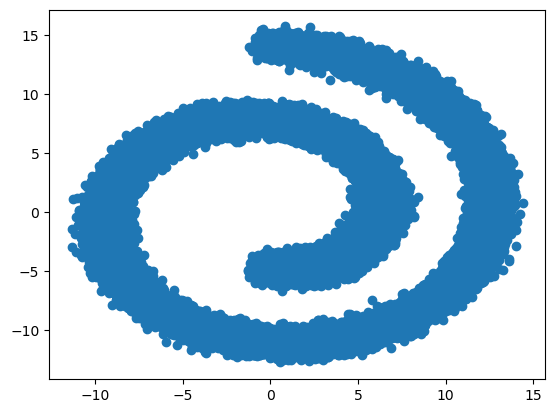

In [2]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [17]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm
import math


def train(model, train_loader, optimizer, scheduler, epoch, grad_clip=None):
    model.train()
    
    train_losses = []
    for batch in train_loader:
        batch['x'] = batch['x'].contiguous().cuda()
        if 'y' in batch:
            batch['y'] = batch['y'].contiguous().cuda()
        loss = model.loss(batch)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            batch['x'] = batch['x'].contiguous().cuda()
            if 'y' in batch:
                batch['y'] = batch['y'].contiguous().cuda()
            loss = model.loss(batch)
            total_loss += loss * batch['x'].shape[0]
        avg_loss = total_loss / len(data_loader.dataset)

    return avg_loss.item()


def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    if step < warmup_steps:
        # Linear warmup
        mul = (step + 1) / warmup_steps
        return mul
    else:
        # Cosine decay
        if use_cos_decay:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return (1 + math.cos(math.pi * progress)) / 2
        else:
            return 1


def train_epochs(model, train_loader, test_loader, train_args, quiet=True):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    warmup_steps = train_args.get('warmup', 0)
    use_cos_decay = train_args.get('use_cos_decay', False)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer, 
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        train_losses.extend(train(model, train_loader, optimizer, scheduler, epoch, grad_clip))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        if not quiet:
            print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses

In [77]:
class DiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, x, y=None):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        item = {'x': self.x[idx]}
        if self.y is not None:
            item['y'] = self.y[idx]
        return item


def collate_fn(batch):
    batched_x = torch.stack([item['x'] for item in batch])
    batched_y = torch.stack([item['y'] for item in batch]) if 'y' in batch[0] else None
    return {'x': batched_x, 'y': batched_y} if batched_y is not None else {'x': batched_x}


class BaseDiffusionModel(nn.Module):
    def __init__(self, predictor):
        """
        Base class for managing diffusion model training
        Args:
            predictor (nn.Module): model that takes in noised inputs `batch_x_t`
                and timesteps `batch_t` and predict noise levels 
        """
        super().__init__()
        self.predictor = predictor
        self.device = 'cuda'

    def sample_batch_t(self, batch_size):
        """
        Sample timesteps t ~ Uniform(0, 1)
        Returns:
            batch_t: shape (batch_size,), timesteps for each sample in a batch
        """
        batch_t = torch.rand(batch_size, 1).to(self.device)
        return batch_t

    def get_alpha_t(self, batch_t, dim):
        """
        Args:
            batch_t (torch.tensor): shape (B, 1)
            dim (int): number of dimensions of the output
        """
        alpha_t = torch.cos(math.pi / 2 * batch_t)
        assert dim in [2, 4]
        if dim == 4:
            alpha_t = alpha_t[:, :, None, None] 
        return alpha_t

    def get_sigma_t(self, batch_t, dim):
        sigma_t = torch.sin(math.pi / 2 * batch_t)
        assert dim in [2, 4]
        if dim == 4:    
            sigma_t = sigma_t[:, :, None, None]
        return sigma_t
    
    def forward_batch_x(self, batch_x):
        """
        Given data `batch_x`, sample timesteps, applies noise to get 
        x_t = alpha_t * x + sigma_t * epsilon 

        Returns:
            batch_x_t: Noised version of batch_x, shape (B, D) or (B, C, H, W)
            batch_t: Sampled diffusion timesteps, shape (B, 1)
            epsilon: Sampled noise, same shape as `batch_x`
        """
        batch_size = batch_x.size(0)

        # Sample t ~ Uniform(0, 1) for each input in a batch
        batch_t = self.sample_batch_t(batch_size)
        
        # Compute the noise levels
        dim = len(batch_x.shape)
        alpha_t = self.get_alpha_t(batch_t, dim)  # shape (B, 1) or (B, 1, 1, 1)
        sigma_t = self.get_sigma_t(batch_t, dim)  # shape (B, 1) or (B, 1, 1, 1)
        
        # Sample epsilon ~ N(0, 1) same shape as x
        epsilon = torch.randn(list(batch_x.size())).to(self.device)
        
        # Compute noised x_t
        batch_x_t = alpha_t * batch_x + sigma_t * epsilon
        
        return batch_x_t, batch_t, epsilon

    def loss(self, batch):
        # Flatten if input is image
        batch_x = batch['x']
        # if len(batch_x.shape) == 4:
        #     B, C, H, W = batch_x.shape
        #     batch_x = batch_x.view(B, C*H*W)
        # B, D = batch_x.shape

        batch_x_t, batch_t, epsilon = self.forward_batch_x(batch_x)
        # Estimate epsilon_hat = f_theta(x_t, t)
        batch['x'] = batch_x_t
        epsilon_hat = self.predictor(batch, batch_t)
        
        # Loss on epsilon
        return F.mse_loss(epsilon_hat, epsilon)


def sample(
        model, output_shape, num_steps, which_sampler='ddpm', 
        clip_x_hat=None, y=None, cfg=None, clip_init_noise=None):
    """
    Sample from a diffusion model

    Args:
        output_shape (tuple of ints): shape of the samples
            first dimension is the batch dimension
        num_steps (int): number of timesteps used in sampling
        clip_x_hat (tuple or None): if not none, should be the min and max
            of x_hat = (x_t - sigma_t * \hat{epsilon}) / alpha_t to feed in the sampler
        y (torch.tensor): conditional information
        cfg (float): classifier-free guidance weight
    Returns:
        (torch.tensor): shape os output_shape
    """
    with torch.no_grad():
        # Uniformly partition (1, 0) to obtain timesteps
        tsp = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1)
        batch_size = output_shape[0]
        batch_x_t = torch.randn(output_shape).to(model.device)
        if clip_init_noise:
            batch_x_t = torch.clamp(batch_x_t, clip_init_noise[0], clip_init_noise[1])
        
        for i in range(num_steps):
            t = tsp[i]
            tm1 = tsp[i + 1]
            batch_t = torch.full((batch_size, 1), t).to(model.device)
            batch_tm1 = torch.full((batch_size, 1), tm1).to(model.device)
            batch = dict(x=batch_x_t)
            if y is not None:
                batch = dict(x=batch_x_t, y=y)

            # Classifier-free guidance
            if cfg is not None:
                # CFG with weight = cfg
                assert y is not None
                # y with the null class
                y_null = torch.full((batch_size,), 10).cuda()
                batch_uncond = dict(x=batch_x_t, y=y_null)
                epsilon_hat_uncond = model.predictor(batch_uncond, batch_t)
                epsilon_hat_cond = model.predictor(batch, batch_t)
                epsilon_hat = epsilon_hat_uncond + cfg * (epsilon_hat_cond - epsilon_hat_uncond) 
            else:
                # No CFG, either use unconditional or conditional model
                # depending on whether y is provided
                epsilon_hat = model.predictor(batch, batch_t)
            if which_sampler == 'ddpm':
                batch_x_t = ddpm_sampler(model, batch_x_t, epsilon_hat, batch_t, batch_tm1, clip_x_hat)
            else:
                raise NotImplementedError

        return batch_x_t.detach().cpu().numpy()


def ddpm_sampler(model, batch_x_t, epsilon_hat, batch_t, batch_tm1, clip_x_hat=None):
    """
    Ancestral sampling of x_{t-1} using predicted noise
    """
    # Compute the appropriate noise terms
    dim = len(batch_x_t.shape)
    alpha_t = model.get_alpha_t(batch_t, dim)
    sigma_t = model.get_sigma_t(batch_t, dim)
    alpha_tm1 = model.get_alpha_t(batch_tm1, dim)
    sigma_tm1 = model.get_sigma_t(batch_tm1, dim)
    gamma_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t**2 / alpha_tm1**2)
    
    # Compute each term in the DDIM update
    x_hat = (batch_x_t - sigma_t * epsilon_hat) / alpha_t
    if clip_x_hat is not None:
        x_hat = torch.clamp(x_hat, clip_x_hat[0], clip_x_hat[1])
    x_term = alpha_tm1 * x_hat
    noise_term = torch.sqrt(torch.clamp(sigma_tm1**2 - gamma_t**2, min=0)) * epsilon_hat
    epsilon_t = torch.randn(list(batch_x_t.size())).to(model.device)
    batch_x_tm1 = x_term + noise_term + gamma_t * epsilon_t

    return batch_x_tm1

In [19]:
class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()

        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        model = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.LeakyReLU(0.2))
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, batch, batch_t):
        batch_x = batch['x']
        batch_size = batch_x.shape[0]
        batch_x = batch_x.view(batch_size, -1)
        # Concat x and t --> shape (B, D + 1)
        x = torch.cat([batch_x, batch_t], dim=-1)
        return self.net(x).view(batch_size, *self.output_shape)

In [20]:
def normalize(x):
    return (x - x.mean(axis=0)) / x.std(axis=0) 


def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """
    predictor = MLP(input_shape=3, output_shape=2, hiddens=[64 for _ in range(4)]).cuda()
    model = BaseDiffusionModel(predictor).cuda()
    train_data = normalize(train_data)
    test_data = normalize(test_data)
    batch_size = 1024
    train_dataset = DiffusionDataset(torch.tensor(train_data).to(dtype=torch.float32))
    test_dataset = DiffusionDataset(torch.tensor(test_data).to(dtype=torch.float32))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    train_args = dict(epochs=100, lr=1e-3, warmup=100, use_cos_decay=True)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)

    # Sample from model
    ckpt = {
        'final_test_loss': test_losses[-1],
        'model_state_dict': model.state_dict(),
    }
    torch.save(ckpt, 'models/q1_model.pt')
    model.eval()
    diffusion_steps = np.power(2, np.linspace(0, 9, 9)).astype(int)
    all_samples = []
    for step in tqdm.tqdm(diffusion_steps):
        samples = sample(model, output_shape=(2000, 2), num_steps=step)
        all_samples.append(samples)
    all_samples = np.stack(all_samples, axis=0)

    return train_losses, test_losses, all_samples

100%|██████████| 9/9 [00:00<00:00, 25.96it/s]


Final Test Loss: 0.4358


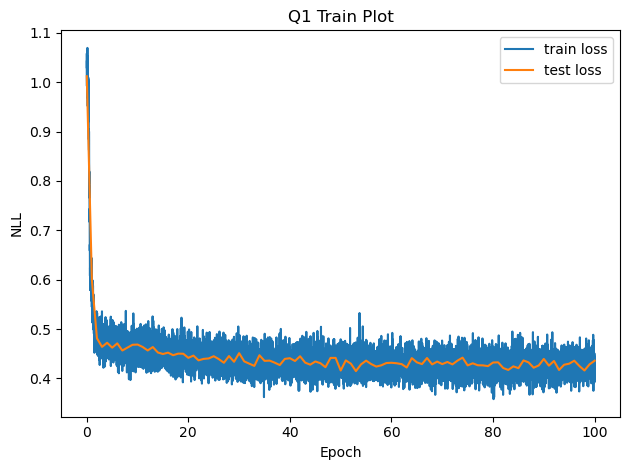

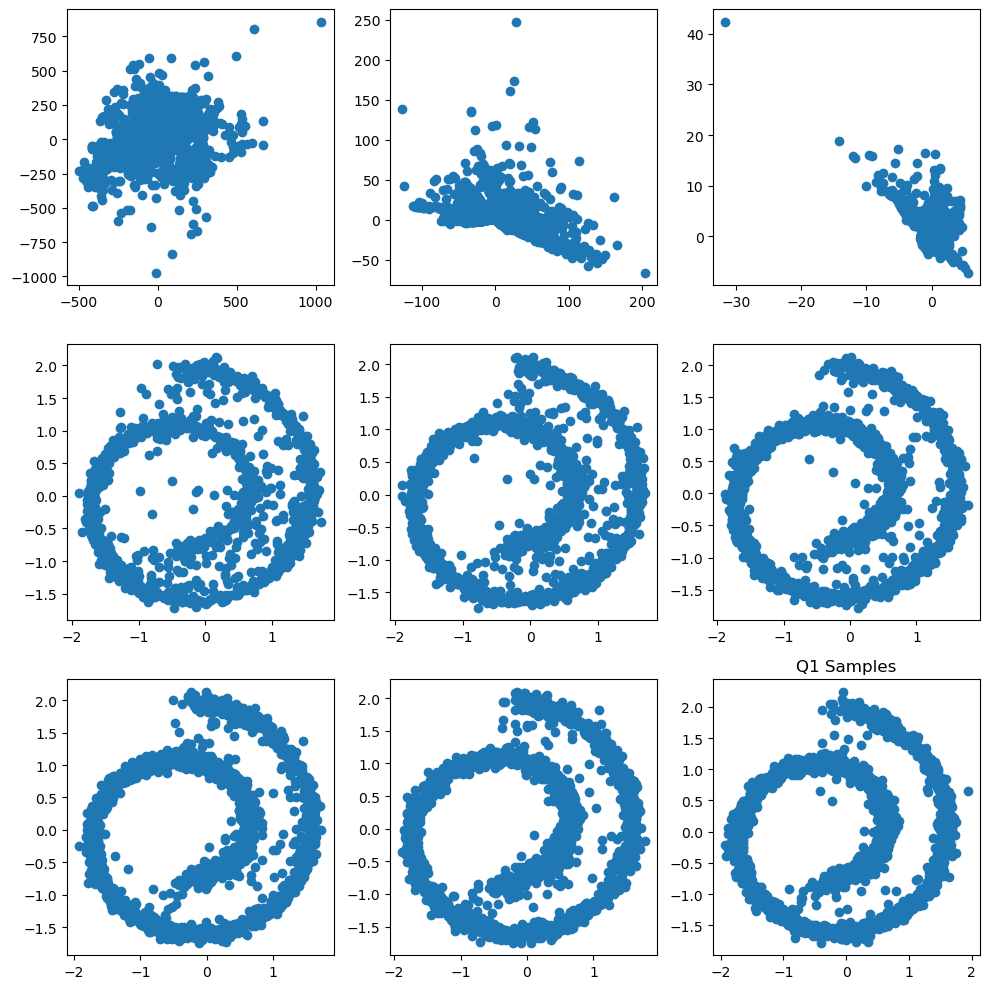

In [21]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


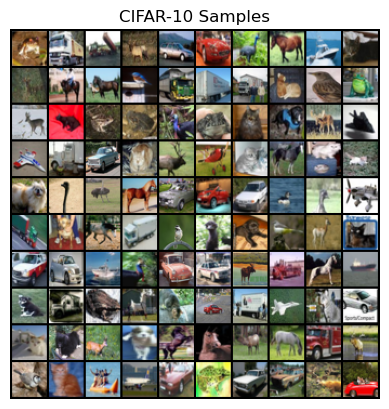

In [7]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [22]:
def timestep_embedding(timesteps, dim, max_period=10000):
    half_dim = dim // 2
    freqs = torch.exp(-np.log(max_period) * torch.arange(0, half_dim, dtype=torch.float32) / half_dim)
    freqs = freqs.to(device=timesteps.device)
    args = timesteps.to(freqs.dtype) * freqs[None]
    embedding = torch.cat((torch.cos(args), torch.sin(args)), dim=-1)
    if dim % 2:
        embedding = torch.cat((embedding, torch.zeros_like(embedding[:, :1])), dim=-1)
    return embedding


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.fc = nn.Linear(temb_channels, out_channels)
        if in_channels != out_channels:
            self.conv_res = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x, temb):
        h = F.silu(self.gn1(self.conv1(x)))
        temb = self.fc(temb)
        h += temb[:, :, None, None]
        h = F.silu(self.gn2(self.conv2(h)))
        if hasattr(self, 'conv_res'):
            x = self.conv_res(x)
        return x + h


class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, hidden_dims, blocks_per_dim):
        super().__init__()
        temb_channels = hidden_dims[0] * 4
        self.emb_fc = nn.Sequential(nn.Linear(hidden_dims[0], temb_channels), nn.SiLU(), nn.Linear(temb_channels, temb_channels))
        self.time_emb_dim = hidden_dims[0]
        self.num_scales = len(hidden_dims)
        self.blocks_per_dim = blocks_per_dim

        self.initial_conv = nn.Conv2d(in_channels, hidden_dims[0], kernel_size=3, padding=1)
        self.blocks = nn.ModuleDict({
            'down_blocks': nn.ModuleList(),
            'up_blocks': nn.ModuleList(),
            'middle_blocks': nn.ModuleList(),
        })
        prev_ch = hidden_dims[0]
        down_block_chans = [prev_ch]
        
        # Build the UNet structure
        # Downward blocks
        for i, hidden_dim in enumerate(hidden_dims):
            for _ in range(blocks_per_dim):
                self.blocks['down_blocks'].append(ResidualBlock(prev_ch, hidden_dim, temb_channels))
                prev_ch = hidden_dim
                down_block_chans.append(prev_ch)
            if i != len(hidden_dims) - 1: 
                self.blocks['down_blocks'].append(Downsample(prev_ch))
                down_block_chans.append(prev_ch)
        
        # Middle blocks
        self.blocks['middle_blocks'].append(ResidualBlock(prev_ch, prev_ch, temb_channels))
        self.blocks['middle_blocks'].append(ResidualBlock(prev_ch, prev_ch, temb_channels))

        # Upward blocks
        for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
            for j in range(blocks_per_dim + 1):
                dch = down_block_chans.pop()
                self.blocks['up_blocks'].append(ResidualBlock(prev_ch + dch, hidden_dim, temb_channels))
                prev_ch = hidden_dim
                if i and j == blocks_per_dim:
                    self.blocks['up_blocks'].append(Upsample(prev_ch))
        
        self.final_gn = nn.GroupNorm(num_groups=8, num_channels=prev_ch)
        self.final_conv = nn.Conv2d(prev_ch, in_channels, 3, padding=1)

    def forward(self, batch, t):
        """
        Args:
            x (torch.tensor): Shape (B, C, H, W)
            t (torch.tensor): Shape (B,)
        """
        x = batch['x']
        # Input to UNet is the noised z_t, need to convert to image shape
        blocks_per_dim = self.blocks_per_dim
        num_scales = self.num_scales
        # B, D = x.shape
        # C, H, W = 3, 32, 32
        # x = x.view(B, C, H, W)
        
        emb = timestep_embedding(t, self.time_emb_dim)
        emb = self.emb_fc(emb)
        h = self.initial_conv(x)
        # To main skip connections
        hs = [h]
        
        # Downward path
        m_idx = 0
        for i in range(num_scales):
            for j in range(blocks_per_dim):
                h = self.blocks['down_blocks'][m_idx](h, emb)
                hs.append(h)
                m_idx += 1
            if i != num_scales - 1:
                h = self.blocks['down_blocks'][m_idx](h)
                hs.append(h)
                m_idx += 1

        assert m_idx == len(self.blocks['down_blocks'])
        
        # Additional blocks at the bottom
        h = self.blocks['middle_blocks'][0](h, emb)
        h = self.blocks['middle_blocks'][1](h, emb)
        
        # Upward path
        m_idx = 0
        for i in reversed(range(num_scales)):
            for j in range(blocks_per_dim + 1):
                h = self.blocks['up_blocks'][m_idx](torch.cat([h, hs.pop()], dim=1), emb)
                m_idx += 1
                if i and j == blocks_per_dim:
                    h = self.blocks['up_blocks'][m_idx](h)
                    m_idx += 1
                    
        assert len(hs) == 0
        assert m_idx == len(self.blocks['up_blocks'])

        # Final normalization and convolution to match the input channels
        h = F.silu(self.final_gn(h))
        # Shape (B, 3, 32, 32)
        out = self.final_conv(h)
        # # Shape (B, D)
        # out = out.view(B, -1)
        return out

In [74]:
def scale_input(data):
    """
    Scale input from [0, 1] to [-1, 1]
    """
    return 2 * data - 1


def reverse_scale_input(data):
    """
    Scale input from [-1, 1] to [0, 1]
    """
    return (data + 1) / 2


def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    predictor = UNet(in_channels=3, hidden_dims=[64, 128, 256, 512], blocks_per_dim=2).cuda()
    model = BaseDiffusionModel(predictor).cuda()
    train_data =  scale_input(train_data)
    test_data = scale_input(test_data)
    batch_size = 256
    train_dataset = DiffusionDataset(torch.tensor(train_data).permute(0, 3, 1, 2).to(dtype=torch.float32))
    test_dataset = DiffusionDataset(torch.tensor(test_data).permute(0, 3, 1, 2).to(dtype=torch.float32))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    train_args = dict(epochs=60, lr=1e-3, warmup=100, use_cos_decay=True)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)
    ckpt = {
        'final_test_loss': test_losses[-1],
        'model_state_dict': model.state_dict(),
    }
    torch.save(ckpt, 'models/q2_model.pt')

    model.eval()
    diffusion_steps = np.power(2, np.linspace(0, 9, 10)).astype(int)
    all_samples = []
    for step in tqdm.tqdm(diffusion_steps):
        samples = sample(model, output_shape=(10, 3, 32, 32), num_steps=step, clip_x_hat=(-1, 1))
        samples = np.transpose(samples, (0, 2, 3, 1))
        all_samples.append(reverse_scale_input(samples))
    all_samples = np.stack(all_samples, axis=0)

    return train_losses, test_losses, all_samples

In [ ]:
q2_save_results(q2)

Files already downloaded and verified
Files already downloaded and verified


 70%|███████   | 42/60 [19:36<08:23, 27.97s/it]

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [85]:
from deepul.utils import show_samples

ckpt = torch.load('models/q2_model.pt')
predictor = UNet(in_channels=3, hidden_dims=[64, 128, 256, 512], blocks_per_dim=2).cuda()
model = BaseDiffusionModel(predictor).cuda()
model.load_state_dict(ckpt['model_state_dict'])
print(f'Number of params: {count_parameters(model):2E}')
print(f"Final test loss: {ckpt['final_test_loss']:.4f}")

# model.eval()
# diffusion_steps = np.power(2, np.linspace(0, 9, 10)).astype(int)
# all_samples = []
# for step in tqdm.tqdm(diffusion_steps):
#     samples = sample(model, output_shape=(10, 3, 32, 32), num_steps=step, clip_x_hat=(-1, 1))
#     samples = np.transpose(samples, (0, 2, 3, 1))
#     all_samples.append(reverse_scale_input(samples))
# all_samples = np.stack(all_samples, axis=0)

# samples = all_samples
# samples = samples.reshape(-1, *samples.shape[2:])
# show_samples(samples * 255.0, fname=None, title=f"Q2 CIFAR-10 generated samples")

Number of params: 5.551808E+07
Final test loss: 0.0619


# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

In [ ]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [36]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """
    x = images.transpose(0, 3, 1, 2)  # shape (B, 3, 32, 32)
    x = scale_input(x)  # map to [-1, 1]
    z = vae.encode(x)
    xhat = vae.decode(z)
    xhat = reverse_scale_input(x)

    x = x.transpose(0, 2, 3, 1)
    xhat = xhat.transpose(0, 2, 3, 1)
    autoencoded_images = np.stack([x[:50], xhat[:50]], axis=1)
    scale_factor = np.std(z.cpu().numpy().flatten())
    
    return autoencoded_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 2, 32, 32, 3)


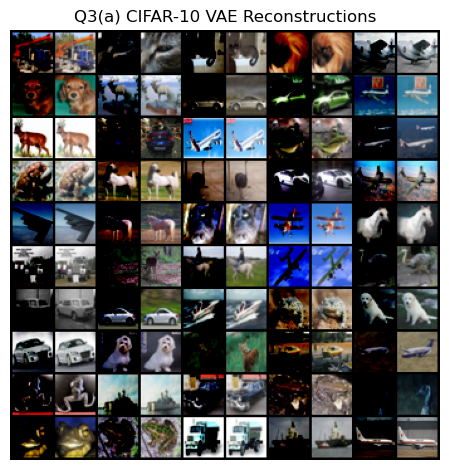

Scale factor: 1.2763


In [37]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [78]:
# DiT Utils

import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F


@dataclass
class DiTConfig:
    input_shape: tuple
    block_size: int
    patch_size: int = 2
    cfg_pdrop: float = 0.1  # Dropout of conditional labels in CFG
    n_classes: int = 10  # Number of classes in training CFG
    model_type: str = "gpt"
    n_layer: int = 12
    n_head: int = 8
    n_embd: int = 512
    embd_pdrop: float = 0.0
    resid_pdrop: float = 0.0
    attn_pdrop: float = 0.0
    use_start_of_sequence_token: bool = False


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        (
            B,
            T,
            C,
        ) = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, device):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return torch.tensor(pos_embed[np.newaxis, ...], device=device)  # (1, M, D)


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

In [79]:
class DiTBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc = nn.Linear(config.n_embd, 6 * config.n_embd)
        nn.init.zeros_(self.fc.weight.data)
        nn.init.zeros_(self.fc.bias.data)
        self.ln1 = nn.LayerNorm(config.n_embd, elementwise_affine=False)
        self.attn = CausalSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd, elementwise_affine=False)
        self.mlp = nn.ModuleDict(
            dict(
                c_fc=nn.Linear(config.n_embd, 4 * config.n_embd),
                c_proj=nn.Linear(4 * config.n_embd, config.n_embd),
                act=nn.GELU(),
                dropout=nn.Dropout(config.resid_pdrop),
            )
        )
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))

    def forward(self, x, c):
        """
        Args:
            x: Shape (B x L x D)
            c: Shape (B x D)
        """
        c = self.fc(F.silu(c))
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)

        h = self.ln1(x)
        h = modulate(h, shift_msa, scale_msa)
        x = x + gate_msa.unsqueeze(1) * self.attn(h)
        
        h = self.ln2(x)
        h = modulate(h, shift_mlp, scale_mlp)
        x = x + gate_mlp.unsqueeze(1) * self.mlpf(h)
        return x


class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, 2 * hidden_size)
        self.ln = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x, c):
        """
        Args:
            x: Shape (B x L x D)
            c: Shape (B x D)
        Returns:
            x: Shape (B, L, D)
        """
        c = self.fc1(F.silu(c))
        shift, scale = c.chunk(2, dim=1)
        x = self.ln(x)
        x = modulate(x, shift, scale)
        x = self.fc2(x)
        return x


class DiT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.input_shape[1] == config.input_shape[2]
        self.input_shape = config.input_shape
        self.n_embd = config.n_embd
        self.n_patches = config.input_shape[1] // config.patch_size

        self.patchify = nn.Conv2d(
            in_channels=config.input_shape[0], 
            out_channels=config.n_embd, 
            kernel_size=config.patch_size, 
            stride=config.patch_size)
        self.unpatchify = nn.ConvTranspose2d(
            in_channels=config.n_embd, 
            out_channels=config.input_shape[0], 
            kernel_size=config.patch_size, 
            stride=config.patch_size)
        self.cfg_dropout_prob = config.cfg_pdrop
        self.cfg_token = config.n_classes  # token for the "null" class
        
        self.embed_classes = nn.Embedding(config.n_classes + 1, config.n_embd)
        self.dit_blocks = nn.ModuleList([DiTBlock(config) for _ in range(config.n_layer)])
        self.final_layer = FinalLayer(config.n_embd, config.patch_size, config.input_shape[0])
    
    def forward(self, batch, t):
        """
        Args:
            x (B, C, H, W) - image
            y (B) - class label
            t (B) - diffusion timestep
        """
        x, y = batch['x'], batch['y']
        
        B = x.size(0)
        x = self.patchify(x)  # (B, D, H // P, W // P)
        x = x.view(B, self.n_embd, -1).permute(0, 2, 1)  # (B, (H // P * W // P), D)
        # Positional embedding considers inputs as a grid of patches
        # grid_size is the number of patches in each axis
        pos_embed = get_2d_sincos_pos_embed(embed_dim=x.shape[2], grid_size=self.n_patches, device=x.device)  # (1, (H // P * W // P), D)
        x += pos_embed 
        
        t = timestep_embedding(t, dim=self.n_embd) # Same as in UNet
        if self.training:
            # Randomly dropout class to train unconditional image generation
            # by setting it to a specific token
            # Draw indices in the batch to dropout class
            mask_idx = np.random.choice(B, size=int(self.cfg_dropout_prob * B), replace=False)
            mask_idx = torch.tensor(mask_idx).to(t.device)
            y[mask_idx] = self.cfg_token
        y = self.embed_classes(y)  # (B, D)
        c = t + y  # (B, D)
        
        for block in self.dit_blocks:
            x = block(x, c)
        x = self.final_layer(x, c)  # (B, (H // P * W // P), D)
        
        x = x.permute(0, 2, 1).view(B, -1, self.n_patches, self.n_patches)  # (B, D, H // P, W // P)
        x = self.unpatchify(x)  # (B, C, H, W)
        return x

In [80]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """
    config = DiTConfig(input_shape=(4, 8, 8), patch_size=2, block_size=16)
    predictor = DiT(config).cuda()
    model = BaseDiffusionModel(predictor).cuda()
    scale_factor = 1.31

    # Encode input into latent space of vae
    train_data = scale_input(train_data.transpose(0, 3, 1, 2))  # shape (B, 3, 32, 32), value in [-1, 1]
    test_data = scale_input(test_data.transpose(0, 3, 1, 2))  # shape (B, 3, 32, 32), value in [-1, 1]
    train_latents = vae.encode(train_data) / scale_factor  # shape (B, 4, 8, 8)
    test_latents = vae.encode(test_data) / scale_factor  # shape (B, 4, 8, 8)
    batch_size = 256
    train_dataset = DiffusionDataset(x=train_latents, y=torch.tensor(train_labels))
    test_dataset = DiffusionDataset(x=test_latents, y=torch.tensor(test_labels))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
    train_args = dict(epochs=60, lr=1e-3, warmup=100, use_cos_decay=True)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)
    ckpt = {
        'final_test_loss': test_losses[-1],
        'model_state_dict': model.state_dict(),
    }
    torch.save(ckpt, 'models/q3b_model.pt')

    model.eval()
    labels = np.arange(10)
    samples = []
    for class_label in tqdm.tqdm(labels):
        y = torch.full((10,), class_label).cuda()
        z = sample(model, output_shape=(10, 4, 8, 8), num_steps=512, y=y, clip_init_noise=(-3, 3), clip_x_hat=(-20, 20)) * scale_factor
        x = vae.decode(z)  # (B, 3, 32, 32) w/ values in [-1, 1]
        x = reverse_scale_input(x)
        x = x.permute((0, 2, 3, 1)).cpu().numpy() 
        samples.append(x)
    samples = np.stack(samples, axis=0)
    return train_losses, test_losses, samples

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [00:35<00:00,  3.57s/it]

Final Test Loss: 0.3839


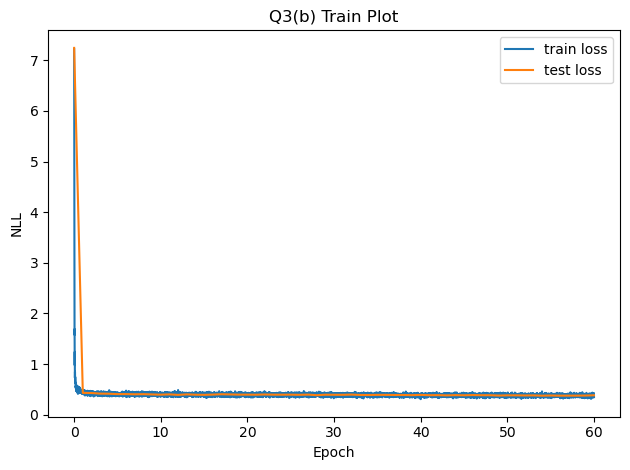

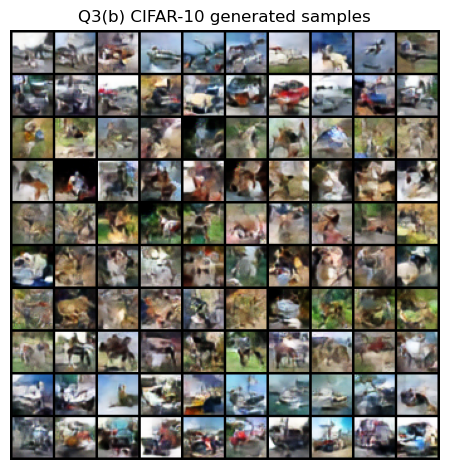

In [81]:
q3b_save_results(q3_b)

In [ ]:
from deepul.hw4_helper import load_pretrain_vae

config = DiTConfig(input_shape=(4, 8, 8), patch_size=2, block_size=16)
predictor = DiT(config).cuda()
ckpt = torch.load('models/q3b_model.pt')
model = BaseDiffusionModel(predictor).cuda()
model.load_state_dict(ckpt['model_state_dict'])
vae = load_pretrain_vae()
scale_factor = 1.2763

model.eval()
labels = np.arange(10)
samples = []
for class_label in tqdm.tqdm(labels):
    y = torch.full((10,), class_label).cuda()
    z = sample(model, output_shape=(10, 4, 8, 8), num_steps=512, y=y) * scale_factor
    x = vae.decode(z)  # (B, 3, 32, 32) w/ values in [-1, 1]
    x = reverse_scale_input(x)
    x = x.permute((0, 2, 3, 1)).cpu().numpy() 
    samples.append(x)
samples = np.stack(samples, axis=0)

samples = samples.reshape(-1, *samples.shape[2:])
show_samples(samples * 255.0, fname=None, title=f"Q3(b) CIFAR-10 generated samples")

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [83]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """
    config = DiTConfig(input_shape=(4, 8, 8), patch_size=2, block_size=16)
    predictor = DiT(config).cuda()
    ckpt = torch.load('models/q3b_model.pt')
    model = BaseDiffusionModel(predictor).cuda()
    model.load_state_dict(ckpt['model_state_dict'])
    scale_factor = 1.31

    cfg_values = [1.0, 3.0, 5.0, 7.5]
    model.eval()
    labels = np.arange(10)
    samples_all_cfg = []
    for cfg in cfg_values:
        samples = []
        for class_label in tqdm.tqdm(labels):
            y = torch.full((10,), class_label).cuda()
            z = sample(model, output_shape=(10, 4, 8, 8), num_steps=512, y=y, cfg=cfg, clip_init_noise=(-3, 3), clip_x_hat=(-20, 20)) * scale_factor
            x = vae.decode(z)  # (B, 3, 32, 32) w/ values in [-1, 1]
            x = reverse_scale_input(x)
            x = x.permute((0, 2, 3, 1)).cpu().numpy() 
            samples.append(x)
        samples = np.stack(samples, axis=0)
        samples_all_cfg.append(samples)
    samples_all_cfg = np.stack(samples_all_cfg, axis=0)
    return samples_all_cfg

100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


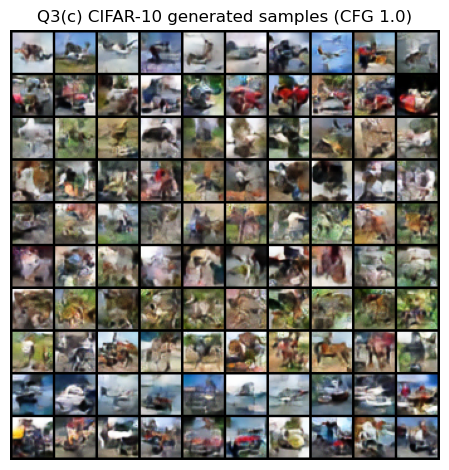

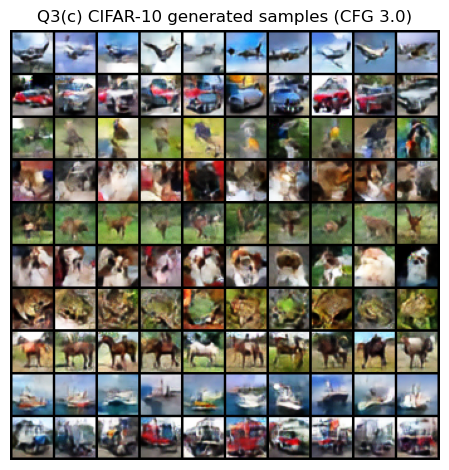

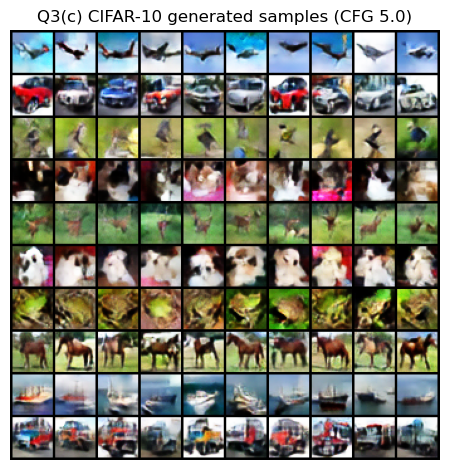

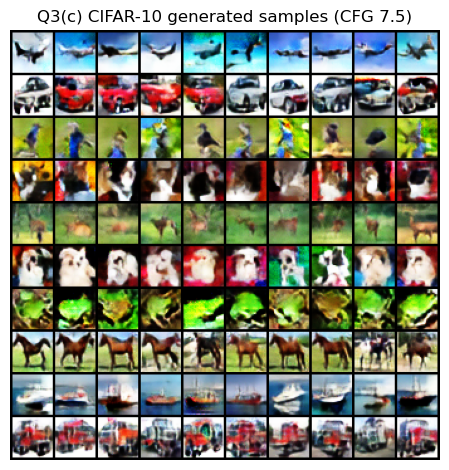

In [84]:
q3c_save_results(q3_c)